In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from scipy import fftpack
from scipy.signal import medfilt

In [6]:
import PIL

In [7]:
root = 'torres_paine_pan.mp4'
cam = cv.VideoCapture(root)


In [8]:
currentframe = 30
vid = cv.VideoCapture(root)

spthreshold=0.999

properties = {'width': int(vid.get(cv.CAP_PROP_FRAME_WIDTH)),
                           'height': int(vid.get(cv.CAP_PROP_FRAME_HEIGHT)),
                           'fps': vid.get(cv.CAP_PROP_FPS)}

y = np.linspace(0, properties['height'], num=properties['height'])
x = np.linspace(0, properties['width'], properties['width'])
X, Y = np.meshgrid(x, y)
noise_angle = 2.0*np.pi*(20*Y + 2*X)
ret,frame = cam.read()
current_original_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
noisy_frame = current_original_frame.copy().astype(np.float32)/255.        
periodic_noise = 0.5 + 0.5*np.cos(noise_angle  - currentframe *0.1)
periodic_noise = periodic_noise.reshape(noisy_frame.shape)
noisy_frame += periodic_noise
noisy_frame /= np.amax(np.abs(noisy_frame))

spprob = np.random.rand(properties['height'], properties['width'])
smask = spprob > spthreshold
pmask = spprob < 1. - spthreshold
noisy_frame[smask] = 1.
noisy_frame[pmask] = 0.
noisy_frame=255*noisy_frame

name = 'frame'+str(currentframe)+'.jpg'
cv.imwrite(name,noisy_frame)
name = 'frame'+str(currentframe+1)+'.jpg'
cv.imwrite(name,frame);

<IPython.core.display.Javascript object>


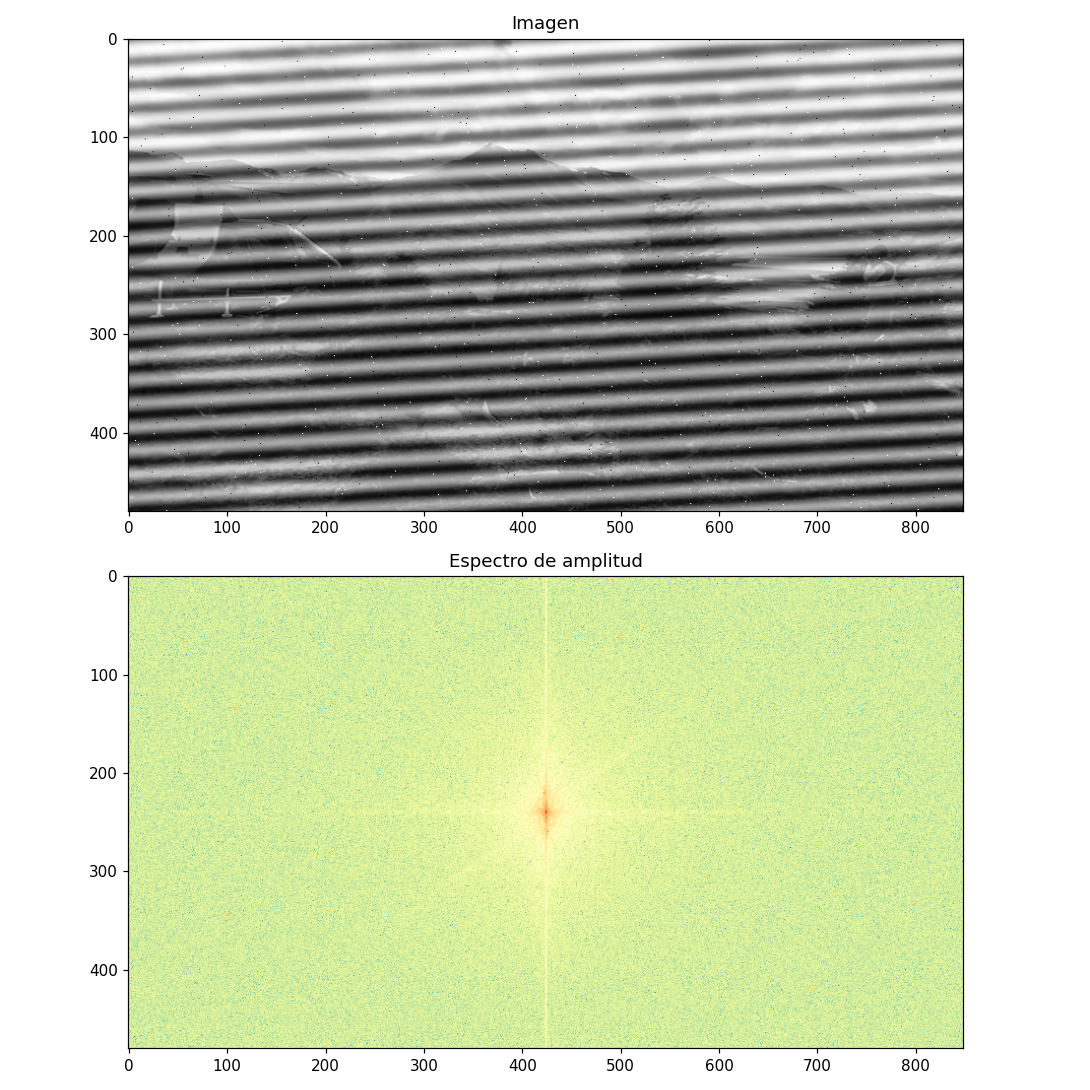

In [9]:

fig, ax = plt.subplots(2, 1, figsize=(10, 10), tight_layout=True)
ax[0].imshow(noisy_frame, cmap=plt.cm.Greys_r) 
ax[0].set_title("Imagen")
S = fftpack.fft2(noisy_frame)
ax[1].imshow(fftpack.fftshift(np.log(1+np.abs(S))), cmap=plt.cm.Spectral_r)
ax[1].set_title("Espectro de amplitud");

In [10]:

def create_mask(dims, frequency, size=3):
    freq_int = int(frequency*dims[0])
    mask = np.ones(shape=(dims[0], dims[1]))
    mask[dims[0]//2-size-freq_int+1:dims[0]//2+size-freq_int, dims[1]//2-size:dims[1]//2+size] = 0 
    mask[dims[0]//2-size+freq_int+1:dims[0]//2+size+freq_int, dims[1]//2-size:dims[1]//2+size] = 0
    return mask


<IPython.core.display.Javascript object>


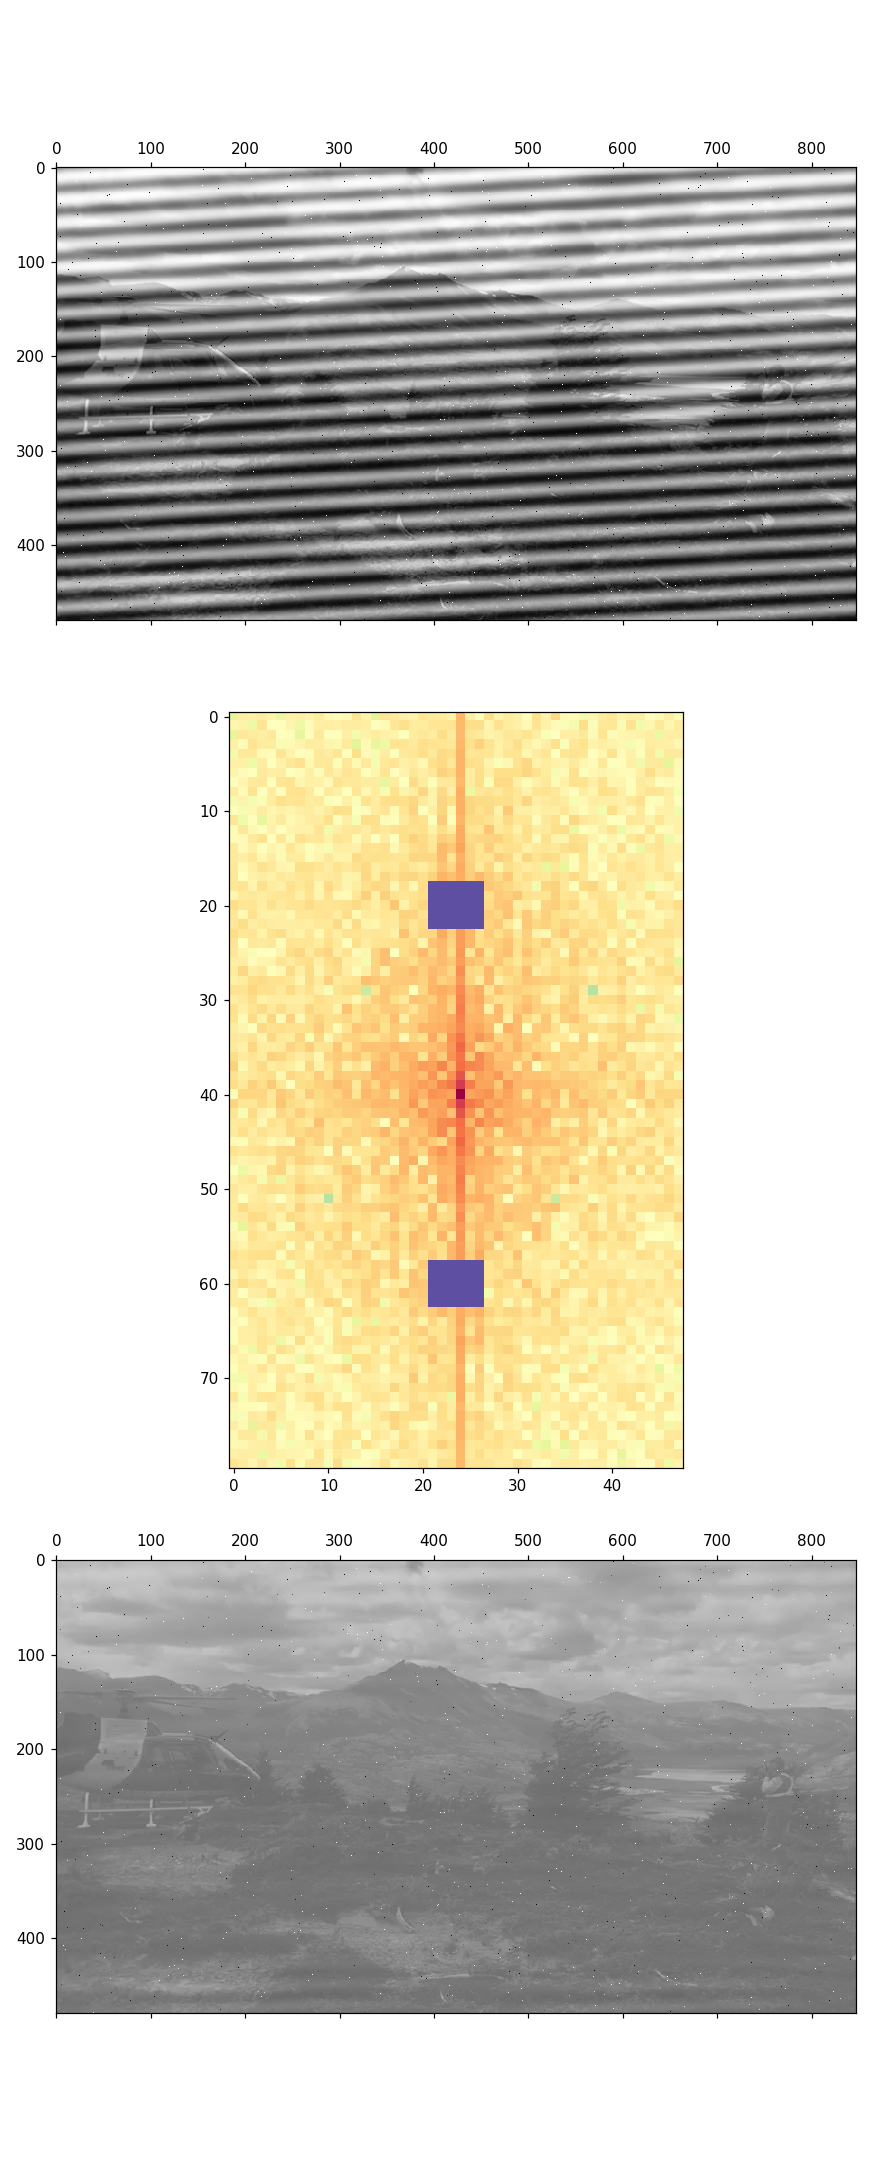

In [11]:

S_img= fftpack.fftshift(fftpack.fft2(noisy_frame))
espectro_filtrado = S_img*create_mask(S_img.shape, 0.042)
img_reconstructed = np.real(fftpack.ifft2(fftpack.ifftshift(espectro_filtrado)))

fig, ax = plt.subplots(3, 1, figsize=(8, 20), tight_layout=True)
ax[0].matshow(noisy_frame, cmap=plt.cm.Greys_r);
ax[1].imshow(np.log(1+np.abs(espectro_filtrado))[200:-200, 400:-400], cmap=plt.cm.Spectral_r)
ax[2].matshow(img_reconstructed, cmap=plt.cm.Greys_r);

name = 'frame'+str(currentframe+2)+'.jpg'
cv.imwrite(name,img_reconstructed);

<IPython.core.display.Javascript object>


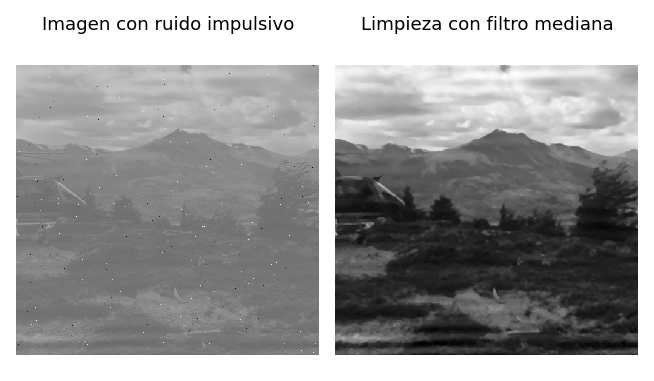

In [12]:


img_filtered = medfilt(img_reconstructed, 5)

fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True, sharex=True, sharey=True)
ax[0].matshow(img_reconstructed[:, 100:600], cmap=plt.cm.Greys_r)     
ax[0].set_title('Imagen con ruido impulsivo')
ax[0].axis('off')
ax[1].matshow(img_filtered[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].set_title('Limpieza con filtro mediana')
ax[1].axis('off');

?medfilt

In [13]:
img_filtered.shape

(480, 848)

In [27]:
imsize = img_filtered.shape

colores_matrix = np.zeros(shape=imsize)

# Se recorre la imagen en bloques de 8x8
for i in range(0, imsize[0], 8):
    for j in range(0, imsize[1], 8):
        
        colores_matrix[i:(i+8),j:(j+8)] = img_filtered[i:(i+8),j:(j+8)]

In [28]:
#Convierte el arreglo de floats a un arreglo de enteros multiplos de m
colores_matrix = colores_matrix.astype(int)
m = 5
new_colores = np.array([x-x%m for x in colores_matrix])

In [93]:
print(new_colores)
#480*848

[[  0   0 170 ... 150   0   0]
 [  0 165 170 ... 150 145   0]
 [165 165 170 ... 150 145 145]
 ...
 [ 80  85  85 ...  75  75  75]
 [  0  80  80 ...  75  75   0]
 [  0   0  80 ...  75   0   0]]


In [89]:
#Se comprimen en una lista de largo flexible
colores_compressed = []
strcolores_compressed = ""

actual = new_colores[0, 0]
anterior = actual
for i in range(imsize[0]):
    
    contador = 0
    
    for j in range(imsize[1]):
        
        actual = new_colores[i, j]
        
        if (new_colores[i, j] == anterior):
            
            contador += 1
        
        else:
            
            colores_compressed.append(contador)
            colores_compressed.append(anterior)
            strcolores_compressed += str(contador) + "!" + str(anterior) + "!"
            anterior = actual
            
print(len(strcolores_compressed))

len(colores_compressed)
len()

361796


98604

In [91]:
message = strcolores_compressed
seq = message.split("!")
seq.pop()

lista = [seq[i:i+64] for i in range(0,len(seq),64)]
lista2=[]
for i in lista:
    lista2.append([i[j:j+8] for j in range(0,len(i),8)])
#print(lista2[0])
lista3 = np.asarray(lista2)
print(len(lista3[-1]))
print(len(seq)/64)
lista3[-1]

6
1540.6875


[['560', '70', '568', '75', '574', '70', '576', '75'],
 ['600', '70', '600', '75', '610', '70', '613', '65'],
 ['623', '70', '627', '65', '629', '70', '631', '75'],
 ['638', '70', '638', '75', '647', '70', '647', '75'],
 ['677', '70', '690', '75', '694', '70', '707', '75'],
 ['712', '70', '725', '75']]

In [65]:
plt.imshow(lista2 , cmap = "gray")

TypeError: Image data of dtype object cannot be converted to float

In [18]:



################
from collections import Counter
Counter(strcolores_compressed).most_common()
################

p = np.linspace(0.01, 0.99, num=100)
H = -p*np.log2(p) - (1-p)*np.log2(1-p)



print("Código de largo fijo:", 4*len(colores_compressed))
# Código de largo variable:
freq = np.array(list(Counter(strcolores_compressed).values()))
p = freq/np.sum(freq)
print("Código de largo variable:", int(-np.sum(p*np.log2(p))*len(strcolores_compressed)))


#print(strcolores_compressed)

# Implemetación adaptada de https://rosettacode.org/wiki/Huffman_coding#Python
import heapq
# Construir dendograma con las probabilidades ordenadas

dendograma = [[frequencia/len(strcolores_compressed), [simbolo, ""]] for simbolo, frequencia in Counter(strcolores_compressed).items()]
heapq.heapify(dendograma)
# Crear el código
while len(dendograma) > 1:
    lo = heapq.heappop(dendograma)
    hi = heapq.heappop(dendograma)
    for codigo in lo[1:]:
        codigo[1] = '0' + codigo[1]
    for codigo in hi[1:]:
        codigo[1] = '1' + codigo[1]
    heapq.heappush(dendograma, [lo[0] + hi[0]] + lo[1:] + hi[1:])
# Convertir código a diccionario
dendograma = sorted(heapq.heappop(dendograma)[1:])
dendograma = {simbolo : codigo for simbolo, codigo in dendograma} 
display(dendograma);


Código de largo fijo: 394416
Código de largo variable: 1148409


{'!': '10',
 '0': '010',
 '1': '110',
 '2': '11111',
 '3': '0001',
 '4': '0000',
 '5': '011',
 '6': '0011',
 '7': '0010',
 '8': '1110',
 '9': '11110'}

In [24]:
strcolores_compressed_codificado = ""
for letra in strcolores_compressed:
    strcolores_compressed_codificado += dendograma[letra]

#display(strcolores_compressed_codificado[:1000])
len(strcolores_compressed_codificado)
#strcolores_compressed_codificado

1155455

In [251]:
b = bytearray()
for i in range(0, len(strcolores_compressed_codificado), 8): 
    byte = strcolores_compressed_codificado[i:i+8]
    b.append(int(byte, 2))

In [253]:

#Se comprimen en una lista de largo flexible
colores_compressed = []

actual = new_colores[0, 0]
anterior = actual
for i in range(imsize[0]):
    
    contador = 0
    
    for j in range(imsize[1]):
        
        actual = new_colores[i, j]
        
        if (new_colores[i, j] == anterior):
            
            contador += 1
        
        else:
            
            colores_compressed.append(contador)
            colores_compressed.append(anterior)
            anterior = actual
            
#print(len(colores_compressed))

####
#colores_compressed_str = np.array_str(np.asarray(colores_compressed))
#print(len(colores_compressed_str))
#print(len(colores_compressed))
#colores_compressed_str


In [254]:
################
from collections import Counter
Counter(colores_compressed).most_common()
################

p = np.linspace(0.01, 0.99, num=100)
H = -p*np.log2(p) - (1-p)*np.log2(1-p)



print("Código de largo fijo:", 4*len(colores_compressed))
# Código de largo variable:
freq = np.array(list(Counter(colores_compressed).values()))
p = freq/np.sum(freq)
print("Código de largo variable:", int(-np.sum(p*np.log2(p))*len(colores_compressed)))


#print(strcolores_compressed)

# Implemetación adaptada de https://rosettacode.org/wiki/Huffman_coding#Python
import heapq
# Construir dendograma con las probabilidades ordenadas

dendograma = [[frequencia/len(colores_compressed), [simbolo, ""]] for simbolo, frequencia in Counter(colores_compressed).items()]
heapq.heapify(dendograma)
# Crear el código
while len(dendograma) > 1:
    lo = heapq.heappop(dendograma)
    hi = heapq.heappop(dendograma)
    for codigo in lo[1:]:
        codigo[1] = '0' + codigo[1]
    for codigo in hi[1:]:
        codigo[1] = '1' + codigo[1]
    heapq.heappush(dendograma, [lo[0] + hi[0]] + lo[1:] + hi[1:])
# Convertir código a diccionario
dendograma = sorted(heapq.heappop(dendograma)[1:])
dendograma = {simbolo : codigo for simbolo, codigo in dendograma} 
#display(dendograma)
len(dendograma)

Código de largo fijo: 393536
Código de largo variable: 761769


785

In [255]:
colores_compressed_codificado = ""
for letra in colores_compressed:
    colores_compressed_codificado += dendograma[letra]

#display(strcolores_compressed_codificado[:1000])
len(colores_compressed_codificado)

764480

In [261]:
b = bytearray()
for i in range(0, len(colores_compressed_codificado), 8): 
    byte = colores_compressed_codificado[i:i+8]
    b.append(int(byte, 2))


187

In [268]:
colores_decoded_codificado = b.decode()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbb in position 0: invalid start byte

<IPython.core.display.Javascript object>


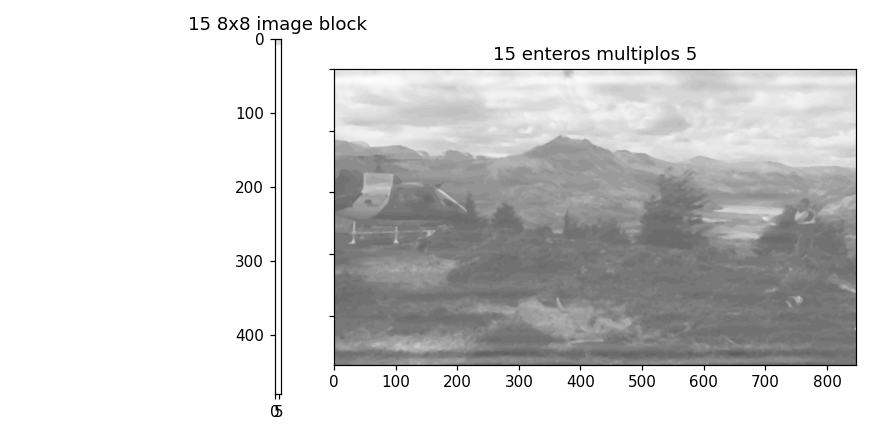

In [252]:
#En teoria esto ya no va

def plot_values(ax, tile, fontsize=14):
    
    mid = (tile.max() + tile.min())/2.
    
    coloresImagen = []
    bloques8x8 = []
    
    
    for i in range(8):
        for j in range(8):
            
            label = tile[i, j]
            
            #Obtiene el color y lo guarda en bloques, truncando el color a multiplos de 5 enteros
            #bloques8x8.append(int(label)-(int(label)%5))
            
            if label > mid:
                color = 'black' 
                
            else:
                color = 'gray'
                
            ax.text(j, i, int(label), fontsize=fontsize, 
                    color=color, ha='center', va='center')
            
        #coloresImagen.append(bloques8x8)
        
    #return bloques8x8
            

#Ver donde agregar el for para obtener todos los bloques con colores        

block_idx = 15
bloque_pixels = img_filtered[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
bloque_dct = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
ax[0].imshow(bloque_pixels, cmap=plt.cm.Greys_r, vmin=img_filtered.min(), vmax=img_filtered.max())
ax[0].set_title("%d 8x8 image block" %(block_idx)); 

#print(bloque_pixels)

ax[1].imshow(new_colores, cmap=plt.cm.Greys_r, vmin=img_filtered.min(), vmax=img_filtered.max())
ax[1].set_title("%d enteros multiplos 5" %(block_idx)); 

